<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/gula_pasir_lokal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fcbf6881e80>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.gula_pasir_lokal.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


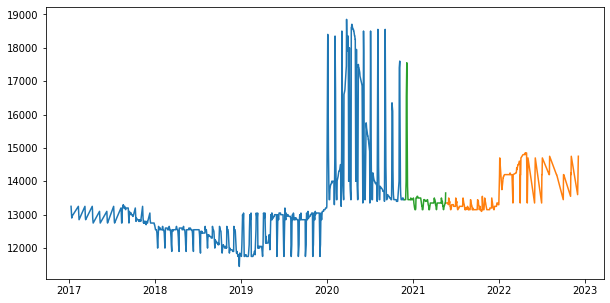

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_gulpas_lokal_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 48ms/step - loss: 0.2690 - mae: 0.4552 - mape: 96.1809 - val_loss: 4.9832e-04 - val_mae: 0.0161 - val_mape: 2756906.5000
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.1901 - mae: 0.3616 - mape: 71.9485 - val_loss: 0.0046 - val_mae: 0.0645 - val_mape: 5968311.5000
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1441 - mae: 0.2946 - mape: 54.7527 - val_loss: 0.0134 - val_mae: 0.1139 - val_mape: 8650449.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1154 - mae: 0.2398 - mape: 40.2891 - val_loss: 0.0248 - val_mae: 0.1561 - val_mape: 10929538.0000
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0950 - mae: 0.1996 - mape: 30.4205 - val_loss: 0.0367 - val_mae: 0.1904 - val_mape: 12784524.0000
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0816 - mae: 0.1823 - mape: 28.0213 - val_loss: 0.0491 - va

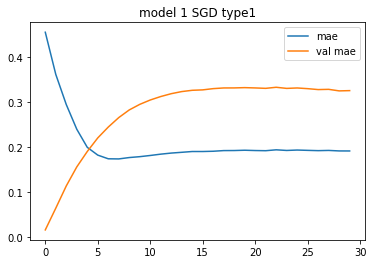

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
1035.2338 7.758105 1140.2055735699594


,date,actual,prediction
0,2021-05-20,13350,14735.377930
1,2021-05-21,13350,14733.142578
2,2021-05-24,13350,14729.778320
3,2021-05-25,13350,14727.052734
4,2021-05-27,13350,14722.120117
...,...,...,...
229,2022-11-02,14250,14813.689453
230,2022-11-03,14200,14810.837891
231,2022-11-04,14750,14808.064453
232,2022-12-01,13600,14805.868164


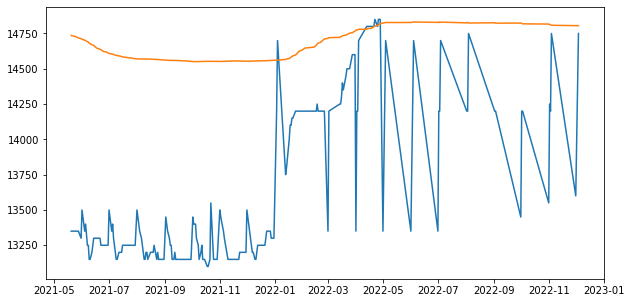

In [ ]:
prediction = forecast_predict(model, test_gulpas_lokal_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_gulpas_lokal = pd.DataFrame()
data_new_gulpas_lokal['date'] = y_test
data_new_gulpas_lokal['actual'] = x_test
data_new_gulpas_lokal['prediction'] = data_result
data_new_gulpas_lokal.to_csv('gulpas_lokal_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_gulpas_lokal.date, data_new_gulpas_lokal.actual)
plt.plot(data_new_gulpas_lokal.date, data_new_gulpas_lokal.prediction)
data_new_gulpas_lokal

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0313 - mae: 0.1252 - mape: 285688.1875 - val_loss: 0.0569 - val_mae: 0.2375 - val_mape: 15336991.0000
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0262 - mae: 0.1117 - mape: 239076.7656 - val_loss: 0.0457 - val_mae: 0.2126 - val_mape: 13990299.0000
Epoch 3/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0242 - mae: 0.1053 - mape: 223665.5312 - val_loss: 0.0353 - val_mae: 0.1865 - val_mape: 12583402.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0225 - mae: 0.1011 - mape: 213227.3281 - val_loss: 0.0266 - val_mae: 0.1616 - val_mape: 11237905.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0211 - mae: 0.0960 - mape: 182975.9688 - val_loss: 0.0240 - val_mae: 0.1533 - val_mape: 10788121.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0202 - mae: 0.0938 - mape: 183845

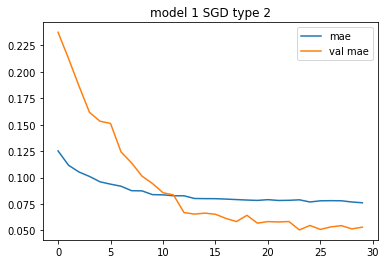

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
287.82135 2.093389 371.67486211068945


,date,actual,prediction
0,2021-05-20,13350,14735.377930
1,2021-05-21,13350,14733.142578
2,2021-05-24,13350,14729.778320
3,2021-05-25,13350,14727.052734
4,2021-05-27,13350,14722.120117
...,...,...,...
229,2022-11-02,14250,14813.689453
230,2022-11-03,14200,14810.837891
231,2022-11-04,14750,14808.064453
232,2022-12-01,13600,14805.868164


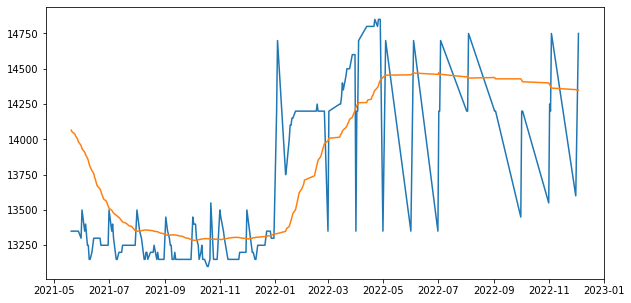

In [ ]:
win_size1 = 60
test_gulpas_lokal_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_gulpas_lokal_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_gulpas_lokal_1 = pd.DataFrame()
data_new_gulpas_lokal_1['actual'] = x_test
data_new_gulpas_lokal_1['prediction'] = data_result_1
data_new_gulpas_lokal_1.to_csv('gulpas_lokal_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_lokal_1.actual)
plt.plot(y_test, data_new_gulpas_lokal_1.prediction)
data_new_gulpas_lokal

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0266 - mae: 0.1040 - mape: 38.5872 - val_loss: 0.0035 - val_mae: 0.0560 - val_mape: 5484454.5000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0264 - mae: 0.1055 - mape: 40.7248 - val_loss: 0.0038 - val_mae: 0.0586 - val_mape: 5634597.5000
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0264 - mae: 0.1053 - mape: 40.6491 - val_loss: 0.0039 - val_mae: 0.0588 - val_mape: 5647770.0000
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0264 - mae: 0.1062 - mape: 41.3147 - val_loss: 0.0038 - val_mae: 0.0585 - val_mape: 5630757.5000
Epoch 5/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0264 - mae: 0.1062 - mape: 41.3669 - val_loss: 0.0037 - val_mae: 0.0576 - val_mape: 5577027.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0264 - mae: 0.1058 - mape: 40.8630 - val_loss: 0.0037 - val_mae: 

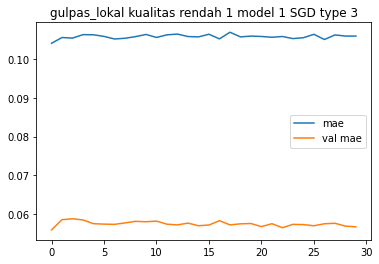

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('gulpas_lokal kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
316.4478 2.328194 396.0928907781608


,actual,prediction
0,13350,14196.130859
1,13350,14182.863281
2,13350,14166.361328
3,13350,14149.259766
4,13350,14127.835938
...,...,...
229,14250,14545.805664
230,14200,14531.427734
231,14750,14518.236328
232,13600,14506.923828


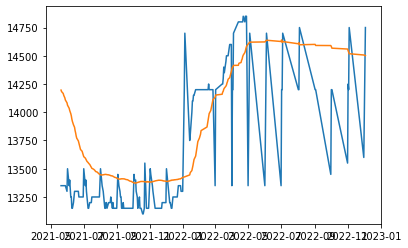

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_gulpas_lokal_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_gulpas_lokal_2 = pd.DataFrame()
# data_new_gulpas_lokal1['date'] = date_test
data_new_gulpas_lokal_2['actual'] = x_test
data_new_gulpas_lokal_2['prediction'] = data_result_2
data_new_gulpas_lokal_2.to_csv('gulpas_lokal_model1_sgd_type3')

plt.plot(y_test, data_new_gulpas_lokal_2.actual)
plt.plot(y_test, data_new_gulpas_lokal_2.prediction)
data_new_gulpas_lokal_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 39ms/step - loss: 0.2453 - mae: 0.4328 - mape: 90.7645 - val_loss: 7.0704e-04 - val_mae: 0.0220 - val_mape: 1689202.6250
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1751 - mae: 0.3431 - mape: 67.6534 - val_loss: 0.0019 - val_mae: 0.0396 - val_mape: 4567678.5000
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0925 - mae: 0.2090 - mape: 35.5563 - val_loss: 0.0186 - val_mae: 0.1348 - val_mape: 9800808.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0515 - mae: 0.1803 - mape: 40.1754 - val_loss: 0.0267 - val_mae: 0.1618 - val_mape: 11260323.0000
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0496 - mae: 0.1823 - mape: 42.1411 - val_loss: 0.0260 - val_mae: 0.1597 - val_mape: 11160323.0000
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0496 - mae: 0.1760 - mape: 39.3623 - val_loss: 0.0258 - val

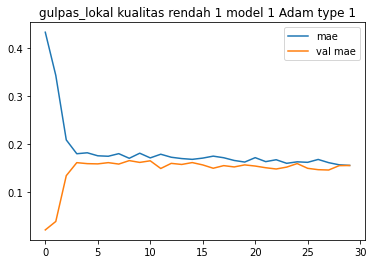

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('gulpas_lokal kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 12ms/step
570.55115 4.2673554 644.2230543453098


,actual,prediction
0,13350,14377.684570
1,13350,14375.919922
2,13350,14347.067383
3,13350,14339.428711
4,13350,14308.209961
...,...,...
229,14250,14641.959961
230,14200,14625.344727
231,14750,14598.258789
232,13600,14586.086914


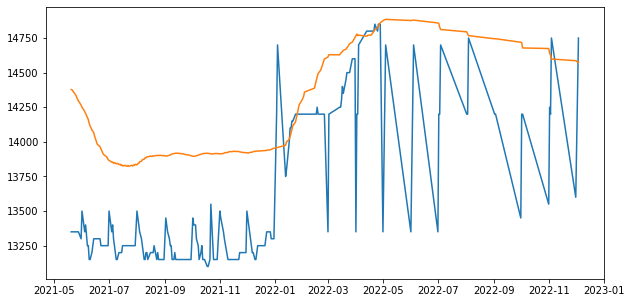

In [ ]:
prediction_a = forecast_predict(model_a, test_gulpas_lokal_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_gulpas_lokal_a = pd.DataFrame()
# data_new_gulpas_lokal1['date'] = date_test
data_new_gulpas_lokal_a['actual'] = x_test
data_new_gulpas_lokal_a['prediction'] = data_result_a
data_new_gulpas_lokal_a.to_csv('gulpas_lokal_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_gulpas_lokal_a.actual)
plt.plot(y_test, data_new_gulpas_lokal_a.prediction)
data_new_gulpas_lokal_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0162 - mae: 0.0779 - mape: 144888.7031 - val_loss: 0.0092 - val_mae: 0.0934 - val_mape: 7625377.5000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0155 - mae: 0.0736 - mape: 139858.7500 - val_loss: 0.0029 - val_mae: 0.0499 - val_mape: 5206003.5000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0151 - mae: 0.0708 - mape: 145119.4375 - val_loss: 0.0021 - val_mae: 0.0417 - val_mape: 4725544.5000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0146 - mae: 0.0682 - mape: 166545.0312 - val_loss: 0.0014 - val_mae: 0.0329 - val_mape: 4186880.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0145 - mae: 0.0685 - mape: 114167.1406 - val_loss: 0.0016 - val_mae: 0.0351 - val_mape: 4319493.5000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0142 - mae: 0.0674 - mape: 143826.6250 

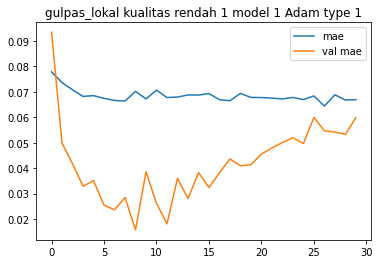

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('gulpas_lokal kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
618.5361 4.547924 783.5827572758349


,actual,prediction
0,13350,14908.374023
1,13350,14923.135742
2,13350,14880.831055
3,13350,14888.984375
4,13350,14840.229492
...,...,...
229,14250,15734.500977
230,14200,15722.950195
231,14750,15700.686523
232,13600,15698.632812


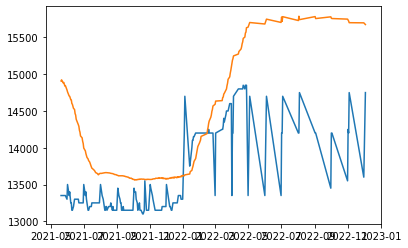

In [ ]:
prediction_a1 = forecast_predict(model_a, test_gulpas_lokal_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_gulpas_lokal_a1 = pd.DataFrame()
data_new_gulpas_lokal_a1['actual'] = x_test
data_new_gulpas_lokal_a1['prediction'] = data_result_a1
data_new_gulpas_lokal_a1.to_csv('gulpas_lokal_model1_adam_type2.csv')

plt.plot(y_test, data_new_gulpas_lokal_a1.actual)
plt.plot(y_test, data_new_gulpas_lokal_a1.prediction)
data_new_gulpas_lokal_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0216 - mae: 0.0954 - mape: 39.1396 - val_loss: 0.0038 - val_mae: 0.0583 - val_mape: 5656893.0000
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0214 - mae: 0.0926 - mape: 36.9990 - val_loss: 0.0039 - val_mae: 0.0592 - val_mape: 5708699.5000
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0214 - mae: 0.0920 - mape: 36.9446 - val_loss: 0.0041 - val_mae: 0.0605 - val_mape: 5783639.5000
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0212 - mae: 0.0914 - mape: 36.7004 - val_loss: 0.0042 - val_mae: 0.0609 - val_mape: 5810843.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0213 - mae: 0.0913 - mape: 36.9173 - val_loss: 0.0042 - val_mae: 0.0612 - val_mape: 5827555.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0213 - mae: 0.0918 - mape: 37.0263 - val_loss: 0.0042 - val_mae: 

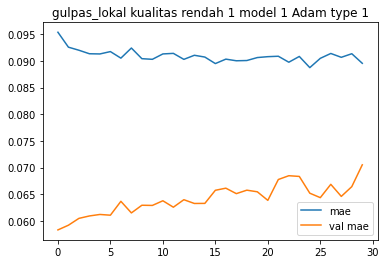

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('gulpas_lokal kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
421.0508 3.0555472 633.0078247936592


,actual,prediction
0,13350,14065.863281
1,13350,14088.944336
2,13350,14079.809570
3,13350,14100.023438
4,13350,14085.888672
...,...,...
229,14250,15617.319336
230,14200,15570.493164
231,14750,15516.875000
232,13600,15477.151367


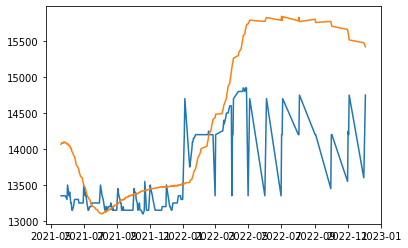

In [ ]:
prediction_a2 = forecast_predict(model_a, test_gulpas_lokal_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_gulpas_lokal_a2 = pd.DataFrame()
# data_new_gulpas_lokal1['date'] = date_test
data_new_gulpas_lokal_a2['actual'] = x_test
data_new_gulpas_lokal_a2['prediction'] = data_result_a2
data_new_gulpas_lokal_a2.to_csv('gulpas_lokal_model1_adam_type3.csv')

plt.plot(y_test, data_new_gulpas_lokal_a2.actual)
plt.plot(y_test, data_new_gulpas_lokal_a2.prediction)
data_new_gulpas_lokal_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 43ms/step - loss: 0.2252 - mae: 0.4020 - mape: 82.1525 - val_loss: 0.0018 - val_mae: 0.0385 - val_mape: 4472204.0000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0722 - mae: 0.2075 - mape: 43.2160 - val_loss: 0.0167 - val_mae: 0.1274 - val_mape: 9349196.0000
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0514 - mae: 0.1800 - mape: 40.2704 - val_loss: 0.0170 - val_mae: 0.1284 - val_mape: 9410819.0000
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0513 - mae: 0.1786 - mape: 39.5703 - val_loss: 0.0202 - val_mae: 0.1404 - val_mape: 10064816.0000
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0494 - mae: 0.1750 - mape: 39.3142 - val_loss: 0.0164 - val_mae: 0.1261 - val_mape: 9306173.0000
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0501 - mae: 0.1773 - mape: 39.8523 - val_loss: 0.0183 - val_mae:

17/17 [==============================] - 0s 7ms/step - loss: 0.0653 - mae: 0.2088 - mape: 53.1897


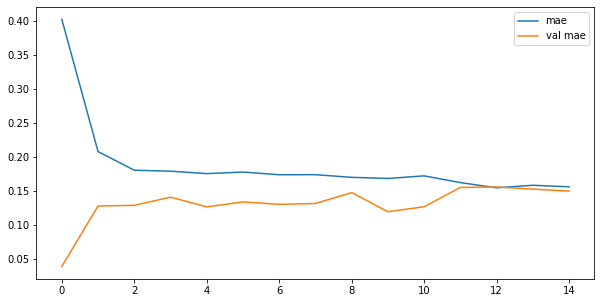

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_gulpas_lokal_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_gulpas_lokal1 = pd.DataFrame()
data_new_gulpas_lokal1['actual'] = x_test
data_new_gulpas_lokal1['prediction'] = data_result1
data_new_gulpas_lokal1.to_csv('gulpas_lokal_model2_adam_type1.csv')

data_new_gulpas_lokal1

131/131 [==============================] - 2s 8ms/step
484.84018 3.623071 552.3691021409506


,actual,prediction
0,13350,14239.983398
1,13350,14168.846680
2,13350,14232.682617
3,13350,14157.447266
4,13350,14209.923828
...,...,...
229,14250,14632.669922
230,14200,14433.812500
231,14750,14579.521484
232,13600,14392.951172


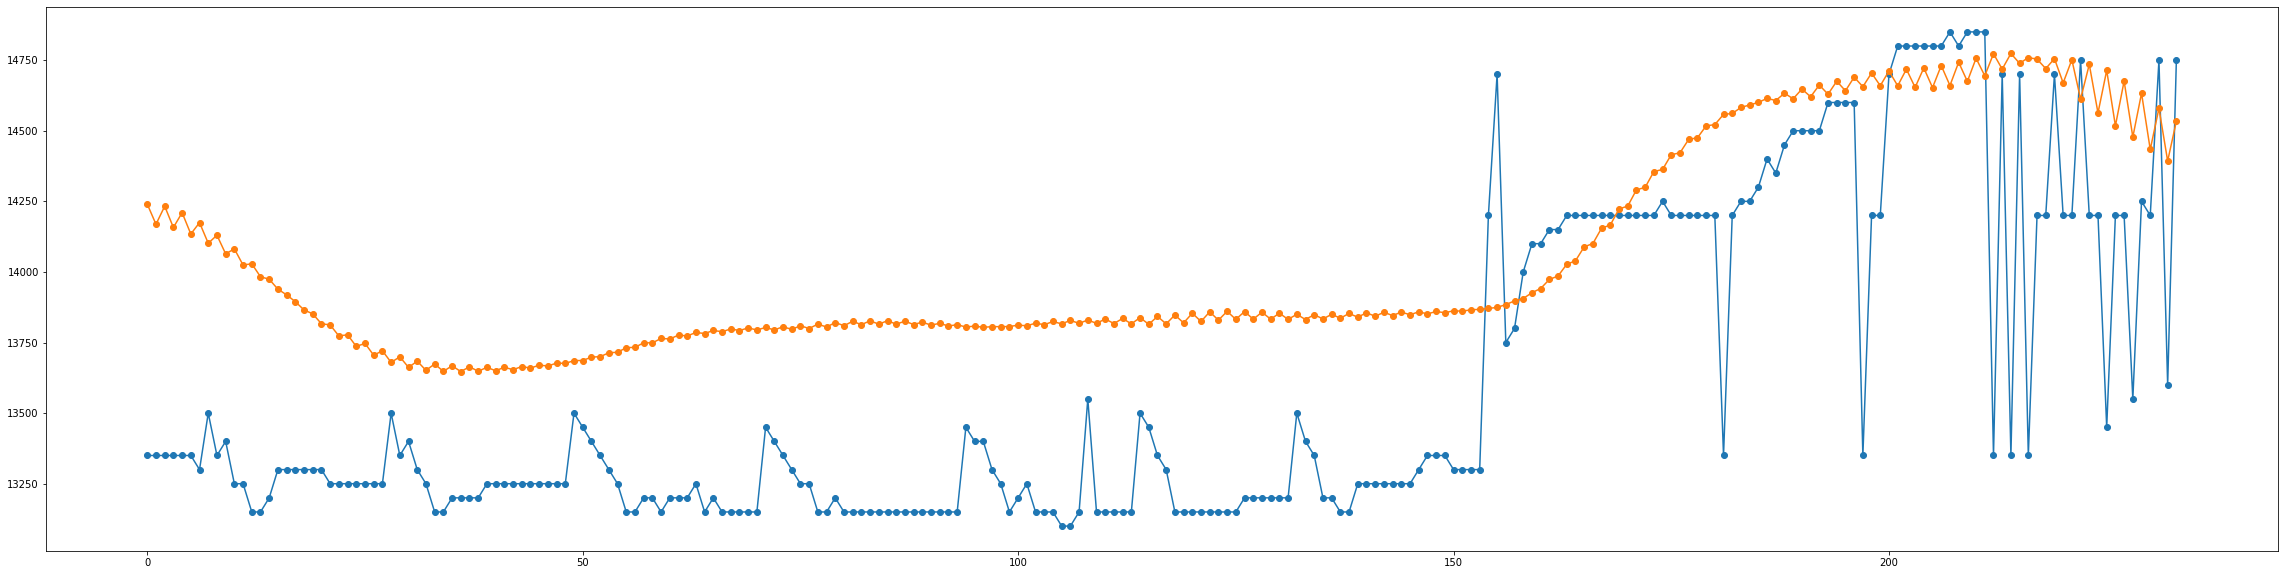

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_gulpas_lokal1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_gulpas_lokal1['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 24s 13ms/step - loss: 0.0182 - mae: 0.0858 - mape: 179403.7812 - val_loss: 0.0051 - val_mae: 0.0681 - val_mape: 6212449.5000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0165 - mae: 0.0761 - mape: 128884.7266 - val_loss: 0.0016 - val_mae: 0.0354 - val_mape: 4353978.5000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0162 - mae: 0.0737 - mape: 144878.9688 - val_loss: 0.0027 - val_mae: 0.0483 - val_mape: 5107377.5000
Epoch 4/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0158 - mae: 0.0723 - mape: 144926.1719 - val_loss: 0.0018 - val_mae: 0.0376 - val_mape: 4484134.5000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0153 - mae: 0.0710 - mape: 142763.3906 - val_loss: 5.1815e-04 - val_mae: 0.0166 - val_mape: 2808292.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0155 - mae: 0.0699 - mape: 140690

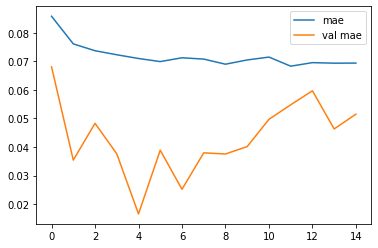

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
273.62054 1.9963434 422.51549527798386


,actual,prediction
0,13350,14359.750977
1,13350,14303.812500
2,13350,14362.550781
3,13350,14291.198242
4,13350,14321.537109
...,...,...
229,14250,14661.102539
230,14200,14559.803711
231,14750,14586.451172
232,13600,14490.659180


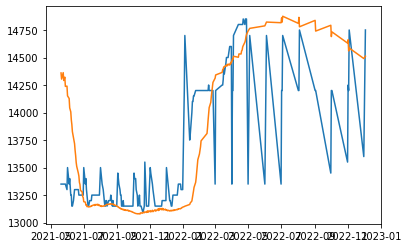

In [14]:
prediction1_1 = forecast_predict(model1, test_gulpas_lokal_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_gulpas_lokal1_1 = pd.DataFrame()
data_new_gulpas_lokal1_1['actual'] = x_test
data_new_gulpas_lokal1_1['prediction'] = data_result1_1
data_new_gulpas_lokal1_1.to_csv('gulpas_lokal_model2_adam_type2.csv')

plt.plot(y_test, data_new_gulpas_lokal1_1.actual)
plt.plot(y_test, data_new_gulpas_lokal1_1.prediction)
data_new_gulpas_lokal1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 17s 47ms/step - loss: 0.0809 - mae: 0.2045 - mape: 65.9017 - val_loss: 0.0127 - val_mae: 0.1108 - val_mape: 8437150.0000
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0323 - mae: 0.1218 - mape: 51.5569 - val_loss: 0.0101 - val_mae: 0.0983 - val_mape: 7771162.0000
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0314 - mae: 0.1196 - mape: 49.0929 - val_loss: 0.0058 - val_mae: 0.0727 - val_mape: 6405038.5000
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0289 - mae: 0.1132 - mape: 45.2890 - val_loss: 0.0044 - val_mae: 0.0632 - val_mape: 5883107.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0278 - mae: 0.1084 - mape: 44.1984 - val_loss: 0.0045 - val_mae: 0.0640 - val_mape: 5935402.0000
Epoch 6/15
84/84 [==============================] - 2s 22ms/step - loss: 0.0276 - mae: 0.1065 - mape: 42.6866 - val_loss: 0.0038 - val_mae:

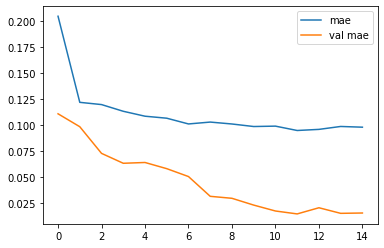

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 5ms/step
264.3394 1.9462664 375.1257705756831


,actual,prediction
0,13350,14227.251953
1,13350,14135.755859
2,13350,14210.657227
3,13350,14111.606445
4,13350,14174.360352
...,...,...
229,14250,14668.872070
230,14200,14362.935547
231,14750,14616.886719
232,13600,14314.731445


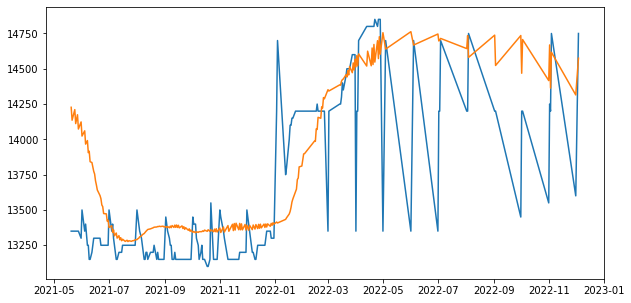

In [ ]:
prediction1_2 = forecast_predict(model1, test_gulpas_lokal_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_gulpas_lokal1_2 = pd.DataFrame()
data_new_gulpas_lokal1_2['actual'] = x_test
data_new_gulpas_lokal1_2['prediction'] = data_result1_2
data_new_gulpas_lokal1_2.to_csv('gulpas_lokal_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_lokal1_2.actual)
plt.plot(y_test, data_new_gulpas_lokal1_2.prediction)

data_new_gulpas_lokal1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 45ms/step - loss: 0.2401 - mae: 0.4267 - mape: 89.2249 - val_loss: 0.0011 - val_mae: 0.0283 - val_mape: 3851611.2500
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1724 - mae: 0.3388 - mape: 66.2998 - val_loss: 0.0123 - val_mae: 0.1086 - val_mape: 8359270.0000
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.1236 - mae: 0.2566 - mape: 44.7083 - val_loss: 0.0349 - val_mae: 0.1855 - val_mape: 12520455.0000
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0927 - mae: 0.1966 - mape: 29.9744 - val_loss: 0.0595 - val_mae: 0.2429 - val_mape: 15619754.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0758 - mae: 0.1793 - mape: 29.0320 - val_loss: 0.0843 - val_mae: 0.2895 - val_mape: 18142202.0000
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0660 - mae: 0.1772 - mape: 31.6850 - val_loss: 0.1029 - val_ma

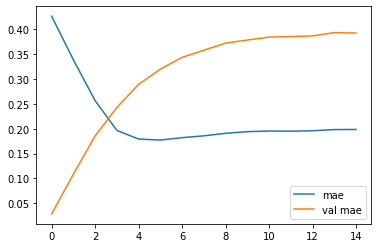

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
1195.1289 8.95188 1307.9288015790462


,actual,prediction
0,13350,14829.162109
1,13350,14826.445312
2,13350,14826.824219
3,13350,14824.004883
4,13350,14823.830078
...,...,...
229,14250,14845.785156
230,14200,14844.236328
231,14750,14844.204102
232,13600,14841.913086


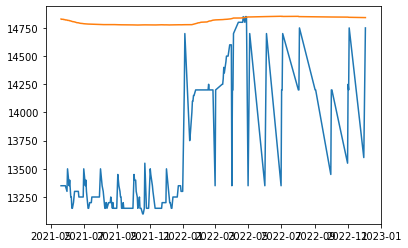

In [ ]:
prediction1_a = forecast_predict(model1_a, test_gulpas_lokal_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_gulpas_lokal1_a = pd.DataFrame()
data_new_gulpas_lokal1_a['actual'] = x_test
data_new_gulpas_lokal1_a['prediction'] = data_result1_a
data_new_gulpas_lokal1_a.to_csv('gulpas_lokal_model2_sgd_type1.csv')


plt.plot(y_test, data_new_gulpas_lokal1_a.actual)
plt.plot(y_test, data_new_gulpas_lokal1_a.prediction)

data_new_gulpas_lokal1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0373 - mae: 0.1358 - mape: 264034.3750 - val_loss: 0.0980 - val_mae: 0.3124 - val_mape: 19376864.0000
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0333 - mae: 0.1257 - mape: 262568.8438 - val_loss: 0.0883 - val_mae: 0.2963 - val_mape: 18510202.0000
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0319 - mae: 0.1213 - mape: 215320.7969 - val_loss: 0.0914 - val_mae: 0.3016 - val_mape: 18794536.0000
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0321 - mae: 0.1221 - mape: 221321.2031 - val_loss: 0.0821 - val_mae: 0.2857 - val_mape: 17938570.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0307 - mae: 0.1162 - mape: 196839.8906 - val_loss: 0.0883 - val_mae: 0.2964 - val_mape: 18515456.0000
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0304 - mae: 0.1206 - mape: 193975.

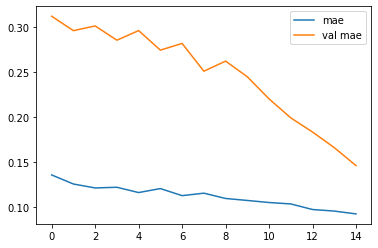

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
439.15604 3.2435532 471.75905860407175


,actual,prediction
0,13350,14092.997070
1,13350,14078.333984
2,13350,14077.777344
3,13350,14060.339844
4,13350,14056.984375
...,...,...
229,14250,14272.125977
230,14200,14256.442383
231,14750,14258.122070
232,13600,14240.843750


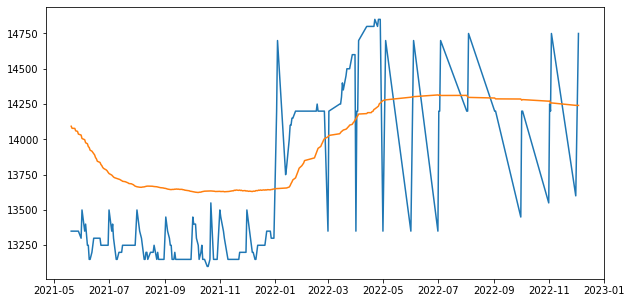

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_gulpas_lokal_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_gulpas_lokal1_a1 = pd.DataFrame()
data_new_gulpas_lokal1_a1['actual'] = x_test
data_new_gulpas_lokal1_a1['prediction'] = data_result1_a1
data_new_gulpas_lokal1_a1.to_csv('gulpas_lokal_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_lokal1_a1.actual)
plt.plot(y_test, data_new_gulpas_lokal1_a1.prediction)
data_new_gulpas_lokal1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0284 - mae: 0.1119 - mape: 47.4703 - val_loss: 0.0121 - val_mae: 0.1076 - val_mape: 8304334.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0284 - mae: 0.1111 - mape: 46.6042 - val_loss: 0.0113 - val_mae: 0.1042 - val_mape: 8117860.5000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0282 - mae: 0.1103 - mape: 46.0605 - val_loss: 0.0112 - val_mae: 0.1037 - val_mape: 8087259.5000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0282 - mae: 0.1109 - mape: 46.4438 - val_loss: 0.0112 - val_mae: 0.1038 - val_mape: 8092578.5000
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0280 - mae: 0.1088 - mape: 44.8388 - val_loss: 0.0108 - val_mae: 0.1016 - val_mape: 7976458.5000
Epoch 6/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0279 - mae: 0.1094 - mape: 45.2151 - val_loss: 0.0107 - val_mae: 

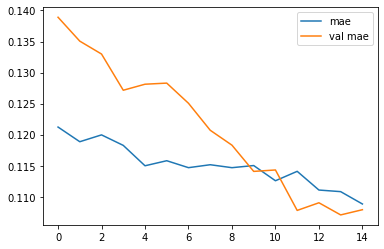

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
378.4649 2.7824168 423.6161292963241


,actual,prediction
0,13350,14116.086914
1,13350,14097.026367
2,13350,14095.707031
3,13350,14072.731445
4,13350,14067.963867
...,...,...
229,14250,14356.546875
230,14200,14335.978516
231,14750,14338.677734
232,13600,14316.202148


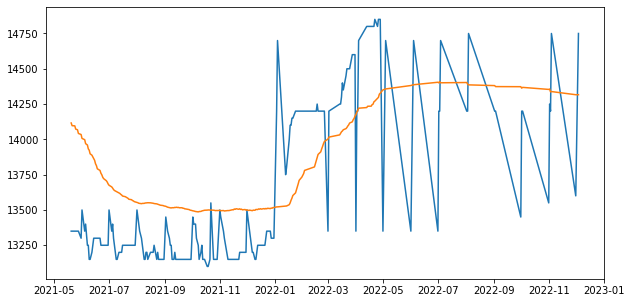

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_gulpas_lokal_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_gulpas_lokal1_a2 = pd.DataFrame()
data_new_gulpas_lokal1_a2['actual'] = x_test
data_new_gulpas_lokal1_a2['prediction'] = data_result1_a2
data_new_gulpas_lokal1_a2.to_csv('gulpas_lokal_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_lokal1_a2.actual)
plt.plot(y_test, data_new_gulpas_lokal1_a2.prediction)

data_new_gulpas_lokal1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.2553 - mae: 0.4433 - mape: 93.3393 - val_loss: 5.4357e-04 - val_mae: 0.0176 - val_mape: 2945617.2500
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1986 - mae: 0.3723 - mape: 74.5329 - val_loss: 0.0054 - val_mae: 0.0701 - val_mape: 6277606.0000
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.1563 - mae: 0.3134 - mape: 59.5293 - val_loss: 0.0152 - val_mae: 0.1213 - val_mape: 9044656.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.1271 - mae: 0.2623 - mape: 46.0469 - val_loss: 0.0282 - val_mae: 0.1667 - val_mape: 11497948.0000
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1060 - mae: 0.2212 - mape: 35.5658 - val_loss: 0.0426 - val_mae: 0.2052 - val_mape: 13579011.0000
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0912 - mae: 0.1932 - mape: 29.2073 - val_loss: 0.0569 - val

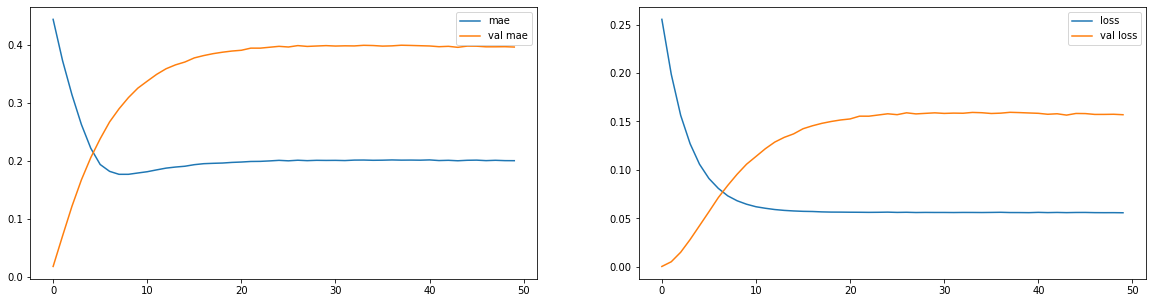

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
1202.9928 9.011937 1318.1669564209233


,actual,prediction
0,13350,14847.288086
1,13350,14845.750000
2,13350,14846.312500
3,13350,14846.867188
4,13350,14843.643555
...,...,...
229,14250,14842.099609
230,14200,14843.729492
231,14750,14842.549805
232,13600,14841.111328


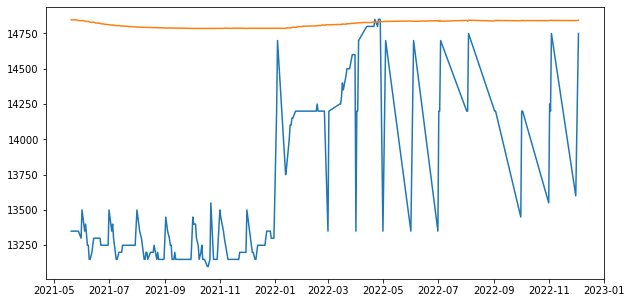

In [ ]:
prediction2 = forecast_predict(model2, test_gulpas_lokal_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_gulpas_lokal2 = pd.DataFrame()
data_new_gulpas_lokal2['actual'] = x_test
data_new_gulpas_lokal2['prediction'] = data_result2
data_new_gulpas_lokal2.to_csv('gulpas_lokal_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_lokal2.actual)
plt.plot(y_test, data_new_gulpas_lokal2.prediction)
data_new_gulpas_lokal2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0444 - mae: 0.1512 - mape: 364399.1562 - val_loss: 0.0793 - val_mae: 0.2807 - val_mape: 17661968.0000
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0350 - mae: 0.1260 - mape: 303045.9375 - val_loss: 0.0783 - val_mae: 0.2790 - val_mape: 17565798.0000
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0341 - mae: 0.1230 - mape: 223343.3125 - val_loss: 0.0815 - val_mae: 0.2846 - val_mape: 17871792.0000
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0334 - mae: 0.1214 - mape: 286969.1562 - val_loss: 0.0825 - val_mae: 0.2864 - val_mape: 17963084.0000
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0335 - mae: 0.1231 - mape: 218302.7500 - val_loss: 0.0737 - val_mae: 0.2705 - val_mape: 17105460.0000
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0327 - mae: 0.1230 - mape: 229159.

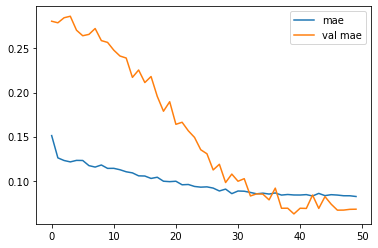

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_gulpas_lokal_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_gulpas_lokal2_1 = pd.DataFrame()
data_new_gulpas_lokal2_1['actual'] = x_test
data_new_gulpas_lokal2_1['prediction'] = data_result2_1
data_new_gulpas_lokal2_1.to_csv('gulpas_lokal_model3_sgd_type2.csv')

data_new_gulpas_lokal2

199/199 [==============================] - 1s 4ms/step
351.71695 2.550128 441.2571529165278


,actual,prediction
0,13350,14847.288086
1,13350,14845.750000
2,13350,14846.312500
3,13350,14846.867188
4,13350,14843.643555
...,...,...
229,14250,14842.099609
230,14200,14843.729492
231,14750,14842.549805
232,13600,14841.111328


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 14ms/step - loss: 0.0297 - mae: 0.1132 - mape: 42.9353 - val_loss: 0.0052 - val_mae: 0.0691 - val_mape: 6105864.5000
Epoch 2/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0298 - mae: 0.1144 - mape: 44.1312 - val_loss: 0.0051 - val_mae: 0.0681 - val_mape: 6046029.0000
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0298 - mae: 0.1150 - mape: 44.7810 - val_loss: 0.0053 - val_mae: 0.0697 - val_mape: 6139455.0000
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0299 - mae: 0.1147 - mape: 44.1617 - val_loss: 0.0052 - val_mae: 0.0693 - val_mape: 6114603.0000
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0300 - mae: 0.1150 - mape: 44.3431 - val_loss: 0.0054 - val_mae: 0.0706 - val_mape: 6186256.5000
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0298 - mae: 0.1139 - mape: 43.5856 - val_loss: 0.0055 - val_mae: 

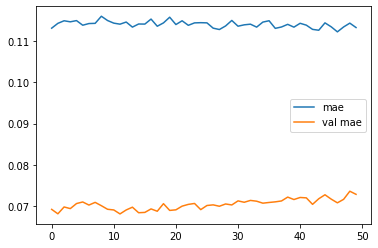

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_gulpas_lokal_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_gulpas_lokal2_2 = pd.DataFrame()
data_new_gulpas_lokal2_2['actual'] = x_test
data_new_gulpas_lokal2_2['prediction'] = data_result2_2
data_new_gulpas_lokal2_2.to_csv('gulpas_lokal_model3_sgd-type3.csv')

data_new_gulpas_lokal2_2

181/181 [==============================] - 1s 4ms/step
378.08945 2.7694662 456.66977264758833


,actual,prediction
0,13350,14327.231445
1,13350,14348.735352
2,13350,14329.744141
3,13350,14283.715820
4,13350,14258.495117
...,...,...
229,14250,14460.493164
230,14200,14414.521484
231,14750,14417.327148
232,13600,14444.744141


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_2 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_13 (LSTM)              (None, 80)                33600     
                                                                 
 dense_16 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 6s 35ms/step - loss: 0.2121 - mae: 0.3909 - mape: 79.8421 - val_loss: 9.5611e-04 - val_mae: 0.0260 - val_mape: 3643633.7500
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0929 - mae: 0.2342 - mape: 47.3879 - val_loss: 0.0108 - val_mae: 0.1019 - val_mape: 7857209.0000
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0678 - mae: 0.2053 - mape: 45.0358 - val_loss: 0.0132 - val_mae: 0.1130 - val_mape: 8480277.0000
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0656 - mae: 0.2017 - mape: 44.2799 - val_loss: 0.0165 - val_mae: 0.1266 - val_mape: 9222576.0000
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0631 - mae: 0.2017 - mape: 44.4417 - val_loss: 0.0240 - val_mae: 0.1536 - val_mape: 10674746.0000
Epoch 6/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0600 - mae: 0.1925 - mape: 41.8254 - val_loss: 0.0240 - val_

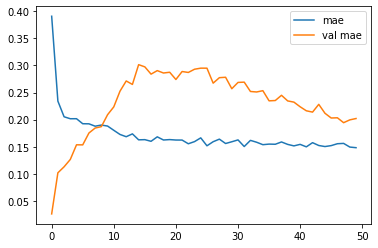

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_gulpas_lokal_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_gulpas_lokal2_a = pd.DataFrame()
data_new_gulpas_lokal2_a['actual'] = x_test
data_new_gulpas_lokal2_a['prediction'] = data_result2_a
data_new_gulpas_lokal2_a.to_csv('gulpas_lokal_model3_adam-type1.csv')

data_new_gulpas_lokal2_a

131/131 [==============================] - 2s 8ms/step
861.2213 6.402047 921.1753701114679


,actual,prediction
0,13350,14121.115234
1,13350,14125.009766
2,13350,14046.627930
3,13350,14048.502930
4,13350,14118.206055
...,...,...
229,14250,15258.798828
230,14200,15233.223633
231,14750,15313.910156
232,13600,15228.298828


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0165 - mae: 0.0784 - mape: 136810.2344 - val_loss: 0.0104 - val_mae: 0.0994 - val_mape: 7695869.5000
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0156 - mae: 0.0745 - mape: 145386.7812 - val_loss: 0.0038 - val_mae: 0.0588 - val_mape: 5414749.5000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0144 - mae: 0.0718 - mape: 148883.3125 - val_loss: 0.0010 - val_mae: 0.0271 - val_mape: 3622730.7500
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0143 - mae: 0.0699 - mape: 119304.7500 - val_loss: 0.0019 - val_mae: 0.0401 - val_mape: 4519723.0000
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0152 - mae: 0.0707 - mape: 120844.9062 - val_loss: 0.0021 - val_mae: 0.0424 - val_mape: 4622369.5000
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0141 - mae: 0.0689 - mape: 138595.4531 

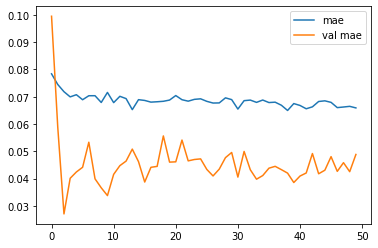

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
605.6728 4.489642 804.8110803163684


,actual,prediction
0,13350,15371.329102
1,13350,15380.618164
2,13350,15143.055664
3,13350,15086.696289
4,13350,15302.329102
...,...,...
229,14250,15452.666992
230,14200,15473.441406
231,14750,15574.106445
232,13600,15515.955078


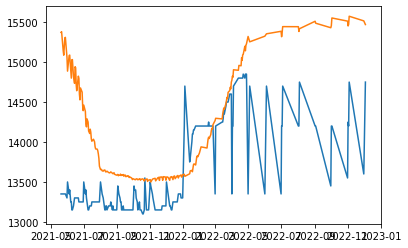

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_gulpas_lokal_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_gulpas_lokal2_a1 = pd.DataFrame()
data_new_gulpas_lokal2_a1['actual'] = x_test
data_new_gulpas_lokal2_a1['prediction'] = data_result2_a1
data_new_gulpas_lokal2_a1.to_csv('gulpas_lokal_model3_adam-type2.csv')

plt.plot(y_test, data_new_gulpas_lokal2_a1.actual)
plt.plot(y_test, data_new_gulpas_lokal2_a1.prediction)
data_new_gulpas_lokal2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0216 - mae: 0.0916 - mape: 40.4087 - val_loss: 0.0026 - val_mae: 0.0475 - val_mape: 4919938.5000
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0212 - mae: 0.0902 - mape: 37.1950 - val_loss: 0.0027 - val_mae: 0.0482 - val_mape: 4963033.5000
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0208 - mae: 0.0885 - mape: 36.6246 - val_loss: 0.0028 - val_mae: 0.0497 - val_mape: 5038687.5000
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0210 - mae: 0.0897 - mape: 36.4871 - val_loss: 0.0028 - val_mae: 0.0500 - val_mape: 5061828.0000
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0208 - mae: 0.0907 - mape: 36.3530 - val_loss: 0.0030 - val_mae: 0.0519 - val_mape: 5160114.5000
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0210 - mae: 0.0895 - mape: 36.5078 - val_loss: 0.0029 - val_mae: 

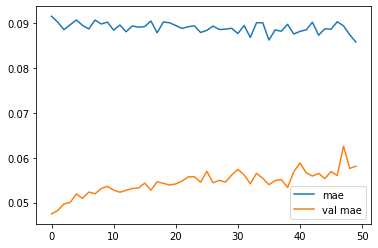

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
385.78683 2.83375 548.4274678569628


,actual,prediction
0,13350,13877.712891
1,13350,13877.510742
2,13350,13915.869141
3,13350,13930.709961
4,13350,13859.921875
...,...,...
229,14250,15654.267578
230,14200,15612.911133
231,14750,15557.323242
232,13600,15591.534180


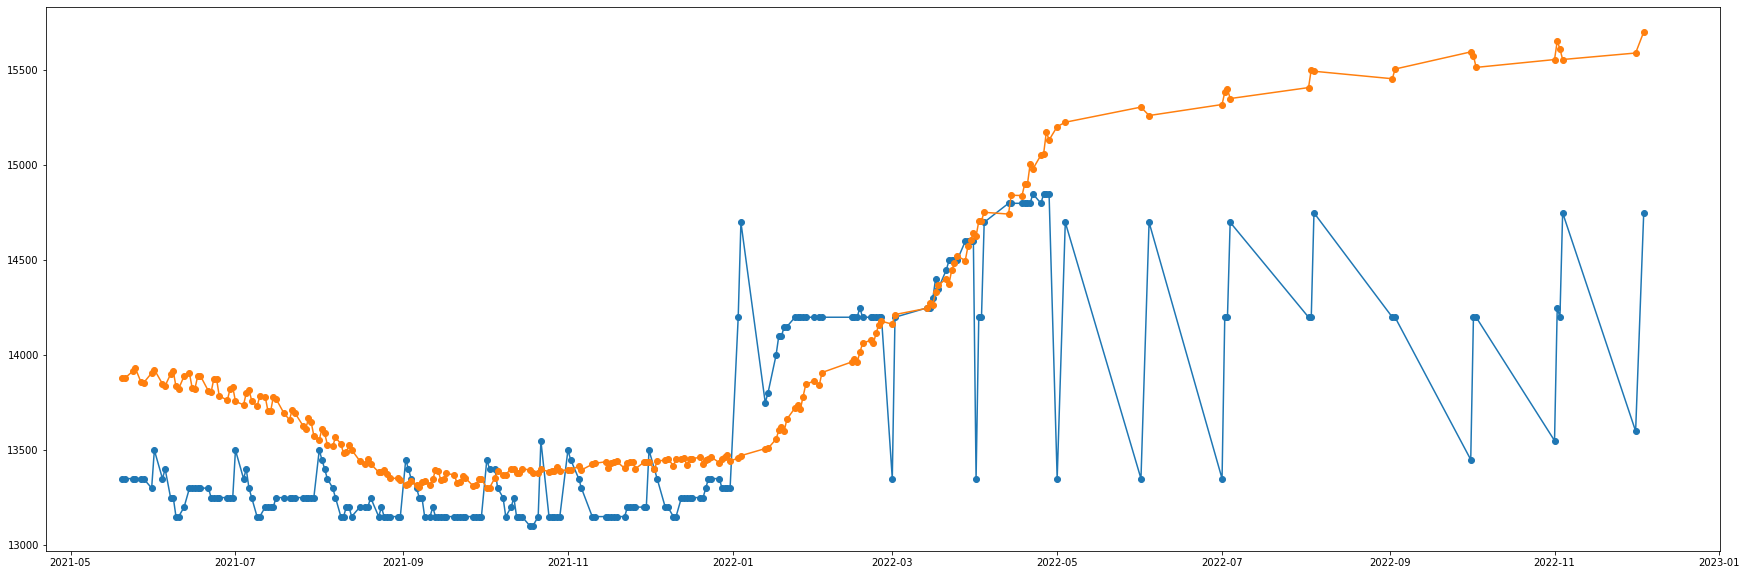

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_gulpas_lokal_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_gulpas_lokal2_a2 = pd.DataFrame()
data_new_gulpas_lokal2_a2['actual'] = x_test
data_new_gulpas_lokal2_a2['prediction'] = data_result2_a2
data_new_gulpas_lokal2_a2.to_csv('gulpas_lokal_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_gulpas_lokal2_a2.actual, '-o')
plt.plot(y_test,data_new_gulpas_lokal2_a2.prediction, '-o')
data_new_gulpas_lokal2_a2